In [23]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

a = 6.11 
b = 6.9
c = 2
p = [0.6, 0.7, 0.8, 0.9]

INTERARRIVAL_RATE = 2/(a+b)              # λ_i
ARRIVAL_RATE = c * INTERARRIVAL_RATE     # λ = c * λ_i
NUMBER_OF_JOBS = 100

In [24]:
def job_generator(env, server):
    for i in range(NUMBER_OF_JOBS):
        interarrival_time = random.uniform(a, b)
        yield env.timeout(interarrival_time)
        arrivals.append(env.now)
        env.process(arrival(f'Job {i + 1}', env, server))

In [25]:
def arrival(name,env,server):
    arrival_time = env.now
    # print('%s arrived at %g' % (name, arrival_time))

    with server.request() as req:
        yield req
        entered_server =  env.now
        # print('%s is assigned to a server at %g' % (name, entered_server))
        sojourn_times.append(entered_server - arrival_time) 
        yield env.process(service(name, env, server))
        # print('%s is done at %g' % (name, env.now))
            
def service(name,env,server):
    duration = random.expovariate(SERVICE_RATE)
    yield env.timeout(duration)
    cum_num_jobs.append(len(server.queue) + len(server.users))

In [26]:
def plot_convergence_graphs(arrivals, sojourn_times, cum_num_jobs,ensemble_wi, avg_num_jobs, conf_int_wi, conf_int_avg_num_jobs):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.plot(arrivals, sojourn_times, label='Ensemble Average of Wi', color='red')
    plt.fill_between(arrivals, y1=conf_int_wi[0], y2=conf_int_wi[1], alpha=0.3, label='Confidence Interval')
    plt.xlabel('Arrivals')
    plt.ylabel('Sojourn Time (Wi)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(arrivals, cum_num_jobs, label='Average Number of Jobs', color='green')
    plt.fill_between(arrivals, conf_int_avg_num_jobs[0], conf_int_avg_num_jobs[1], alpha=0.3, label='Confidence Interval')
    plt.xlabel('Arrivals')
    plt.ylabel('Average of Cumulative Number of Jobs')
    plt.legend()

    plt.tight_layout()
    plt.show()

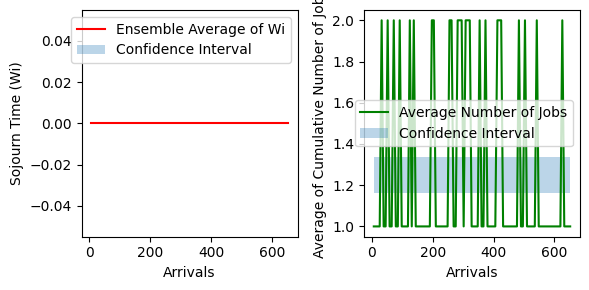

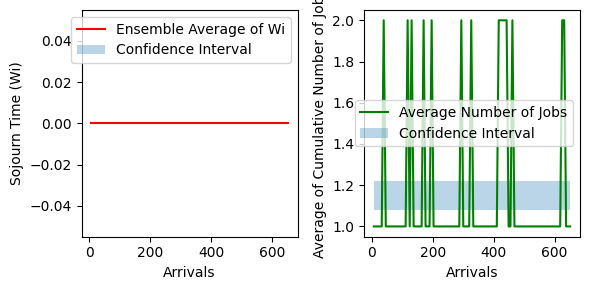

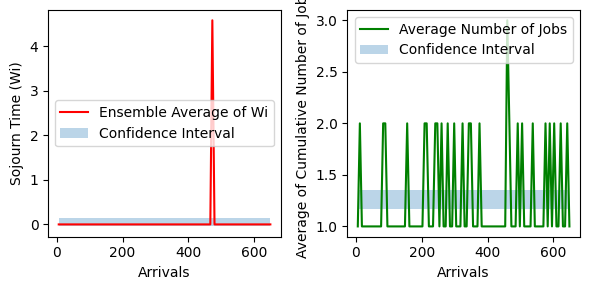

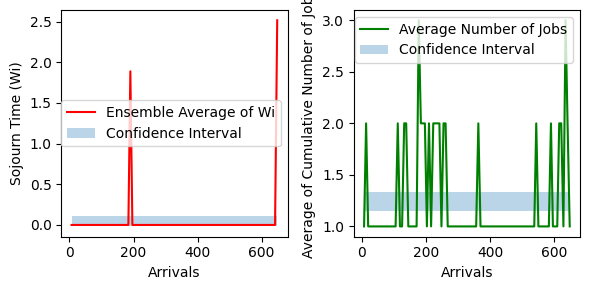

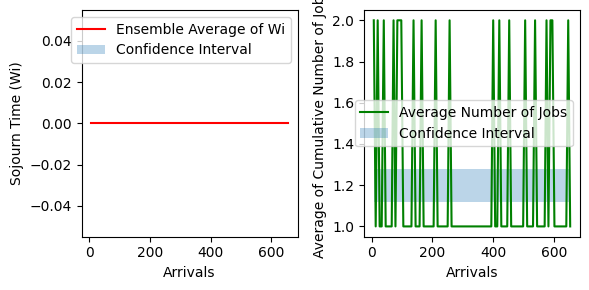

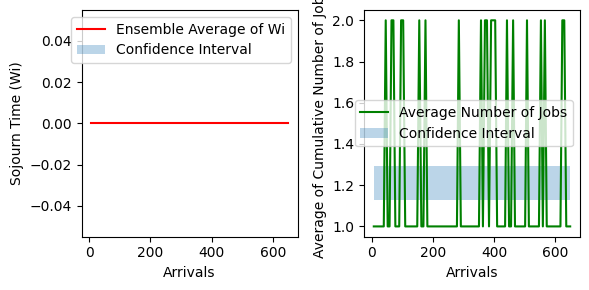

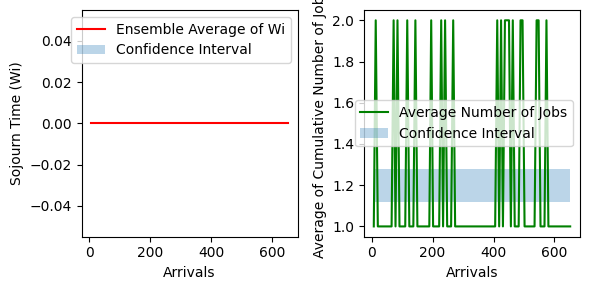

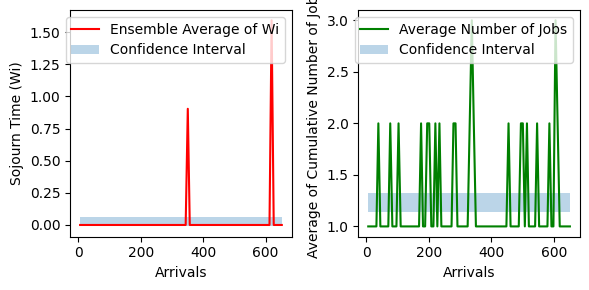

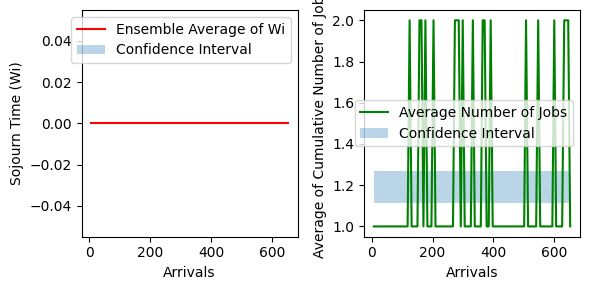

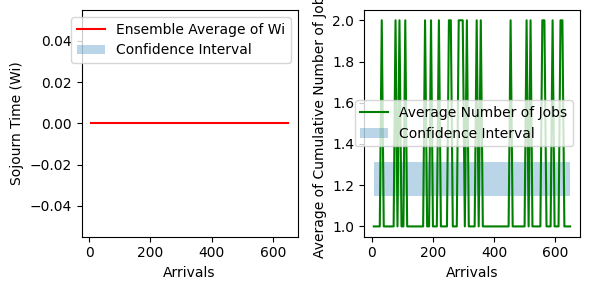

Warmup period for p = 0.6 and 10 replications: [1, 1, 72, 99, 1, 1, 1, 94, 1, 1]


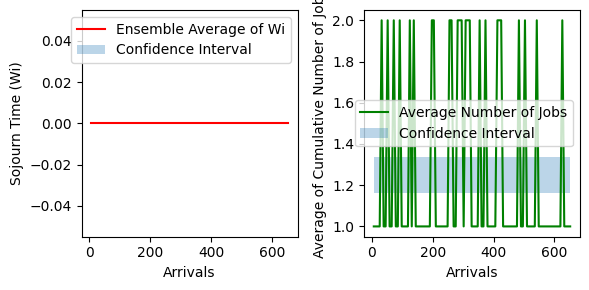

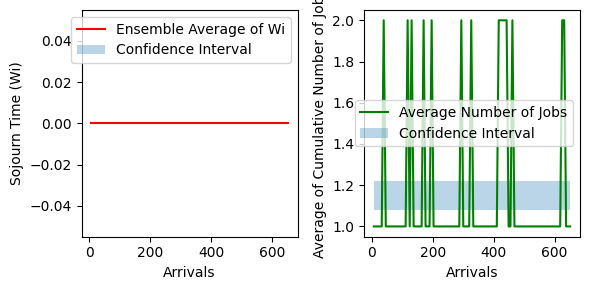

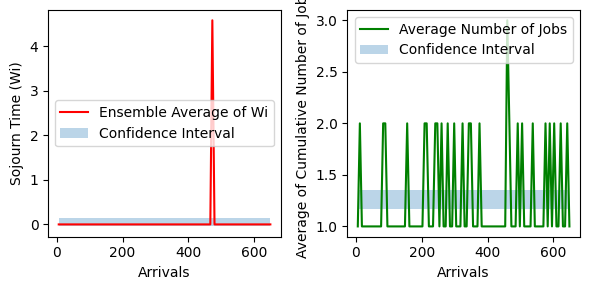

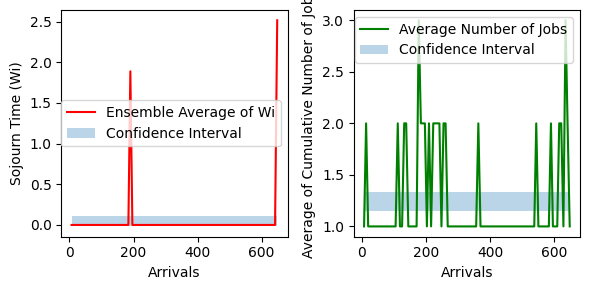

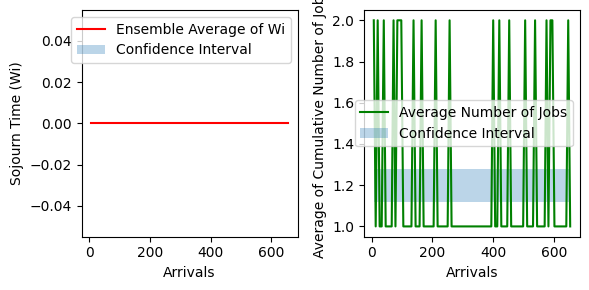

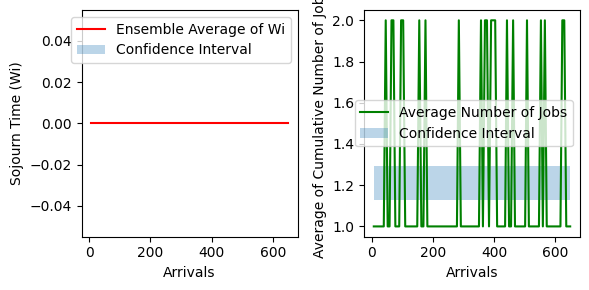

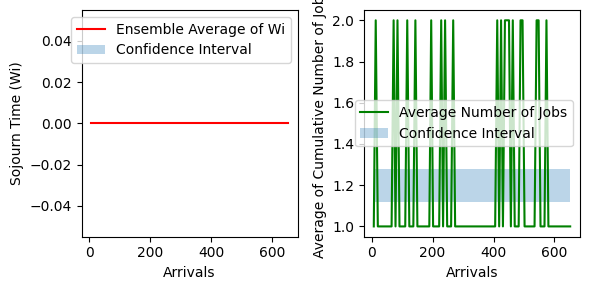

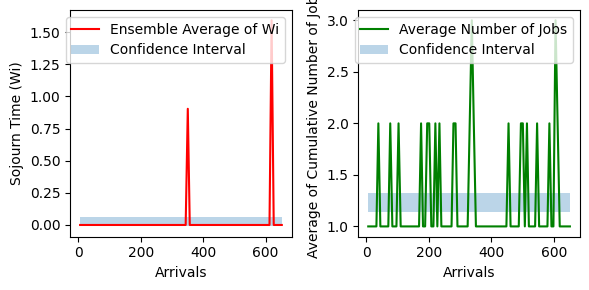

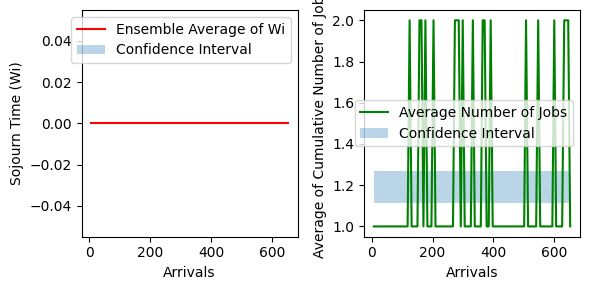

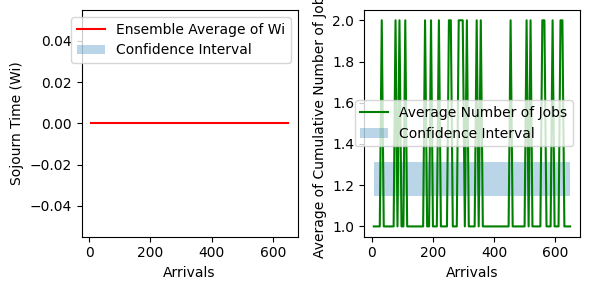

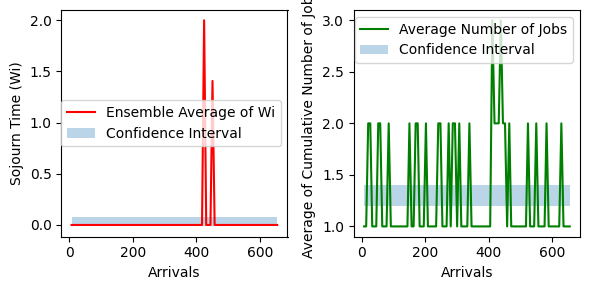

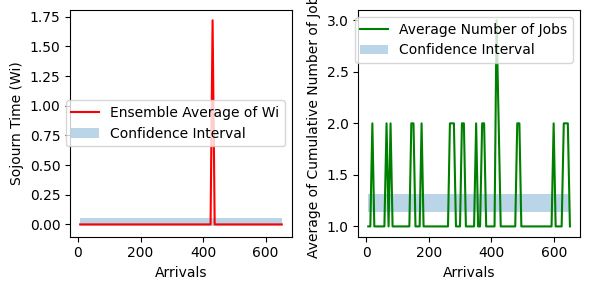

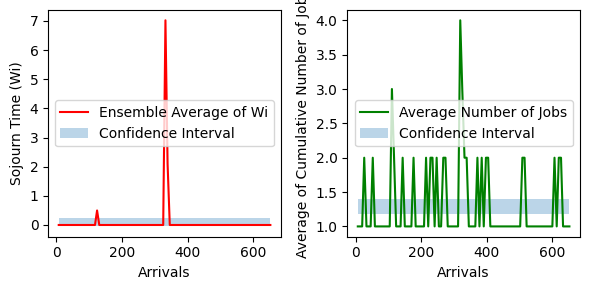

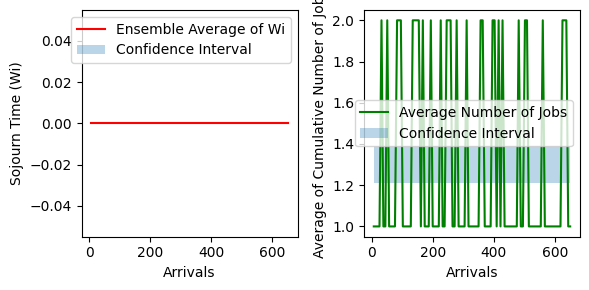

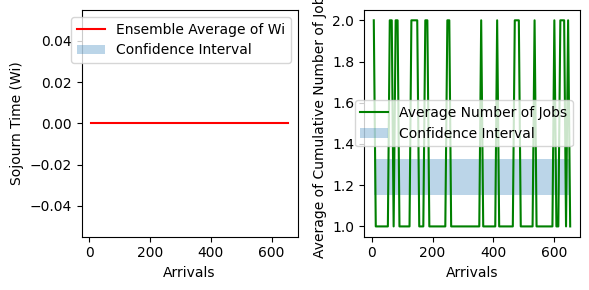

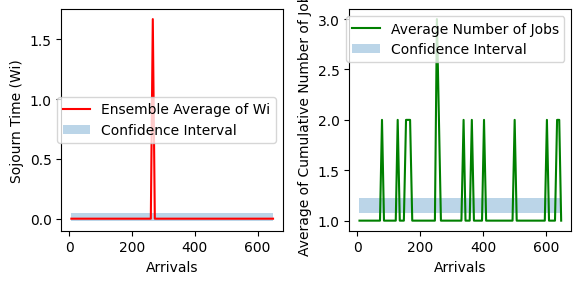

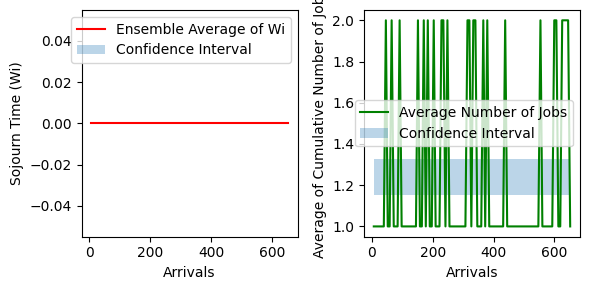

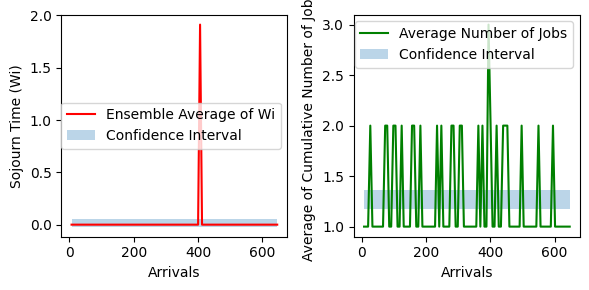

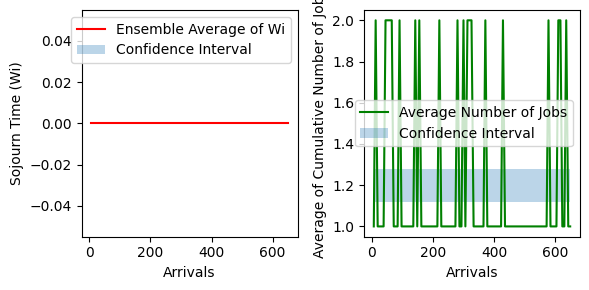

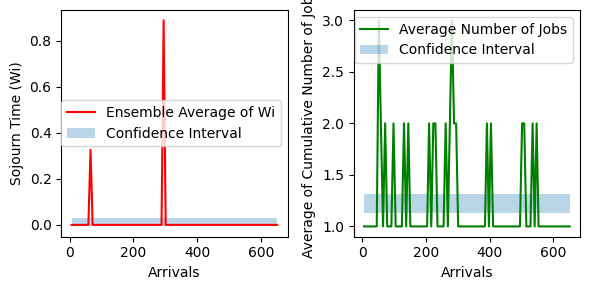

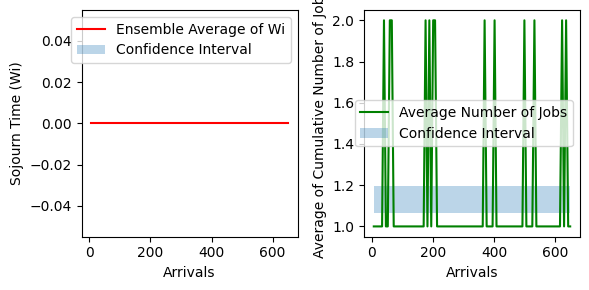

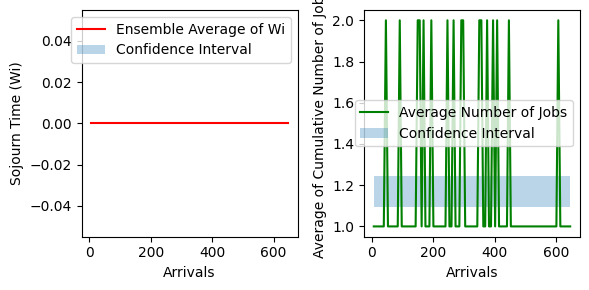

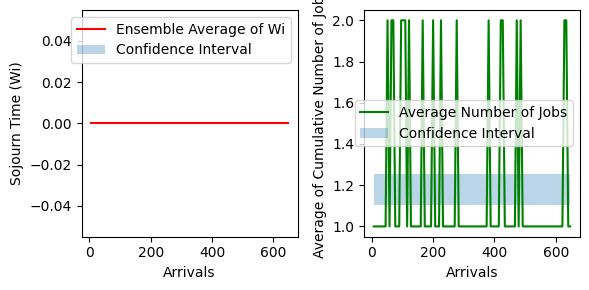

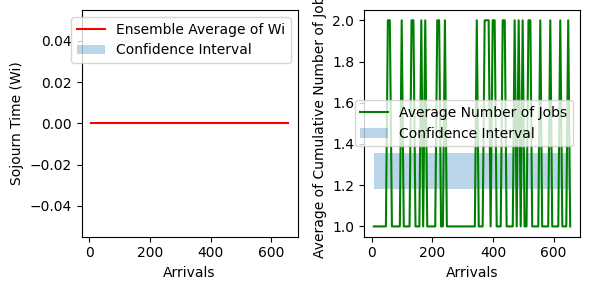

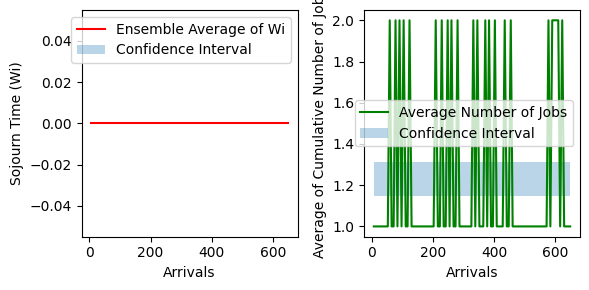

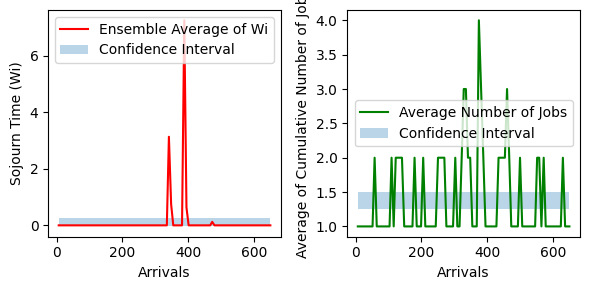

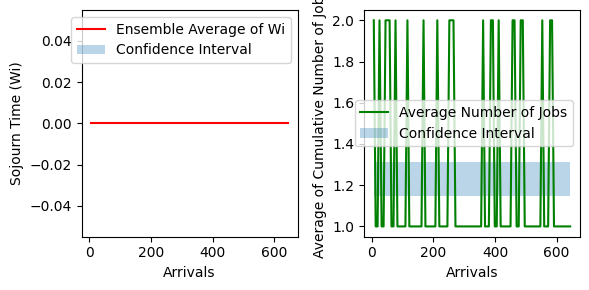

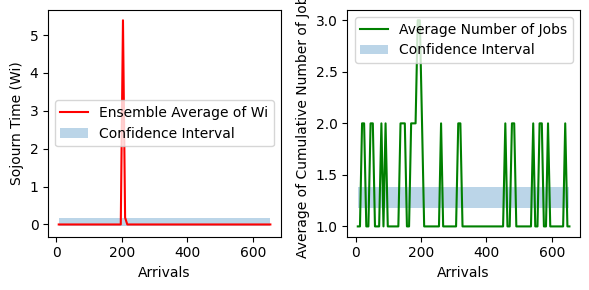

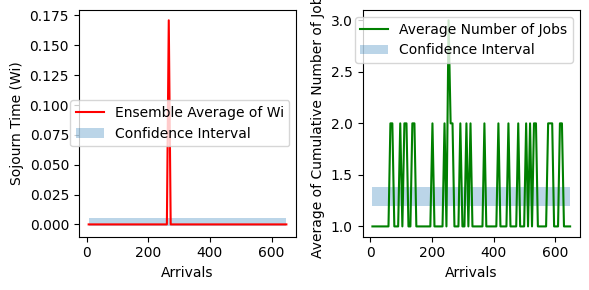

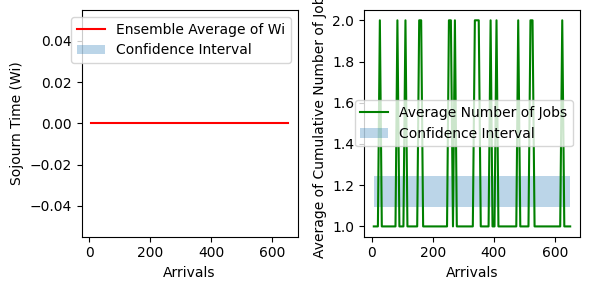

Warmup period for p = 0.6 and 30 replications: [1, 1, 72, 99, 1, 1, 1, 94, 1, 1, 64, 65, 50, 1, 1, 40, 1, 62, 1, 44, 1, 1, 1, 1, 1, 59, 1, 30, 40, 1]


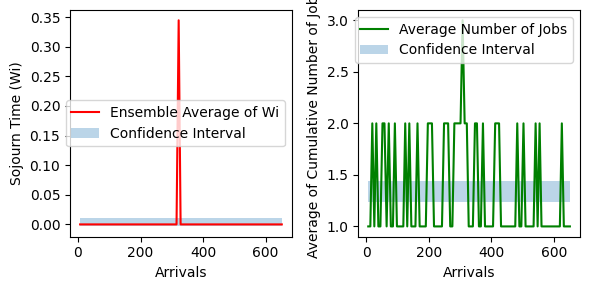

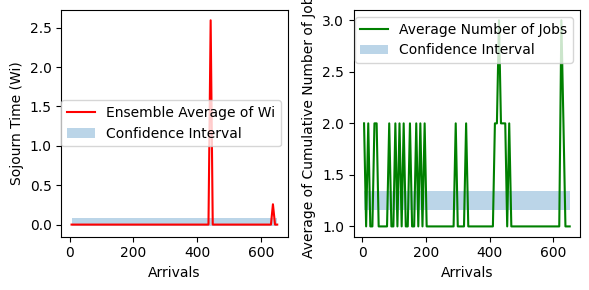

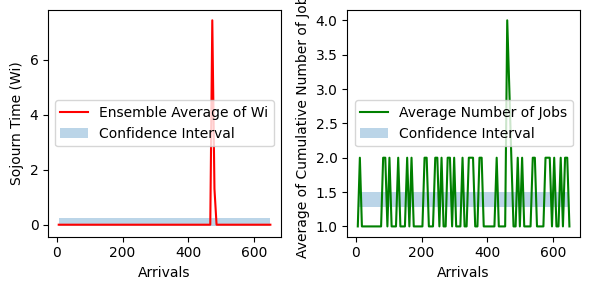

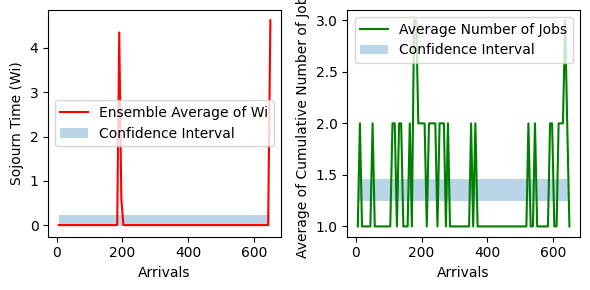

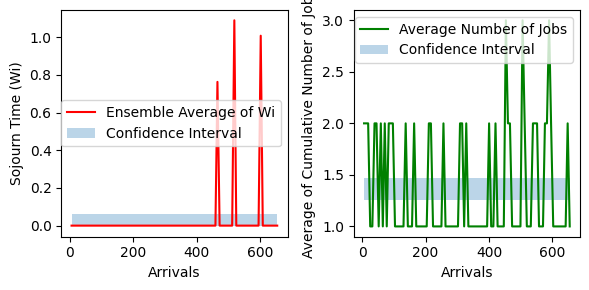

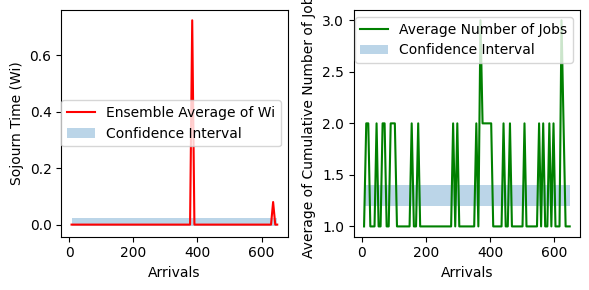

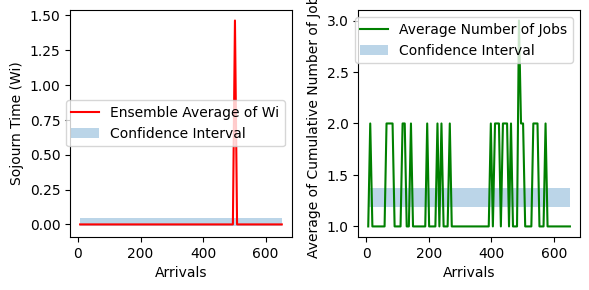

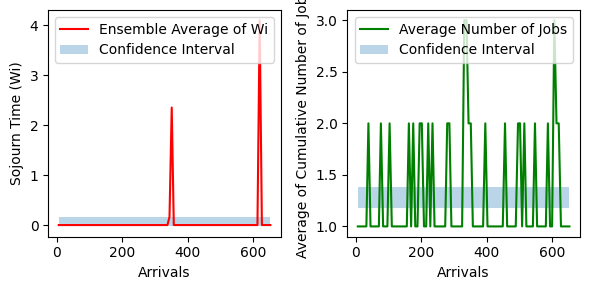

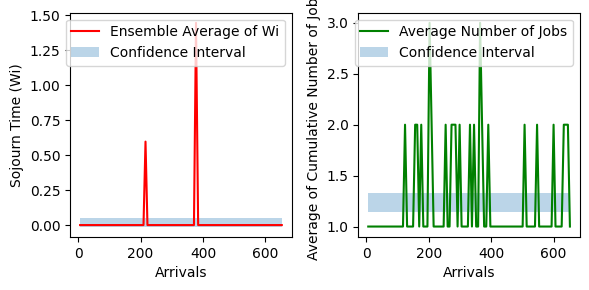

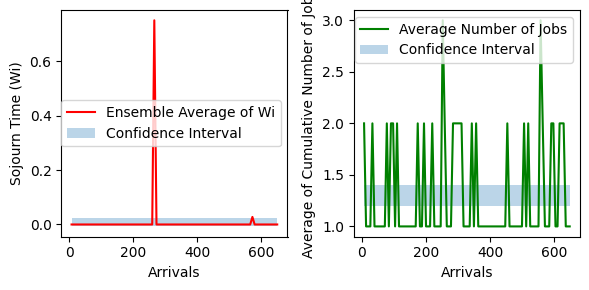

Warmup period for p = 0.7 and 10 replications: [48, 67, 72, 99, 78, 58, 76, 94, 57, 40]


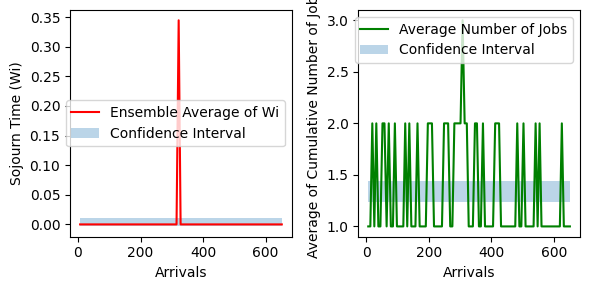

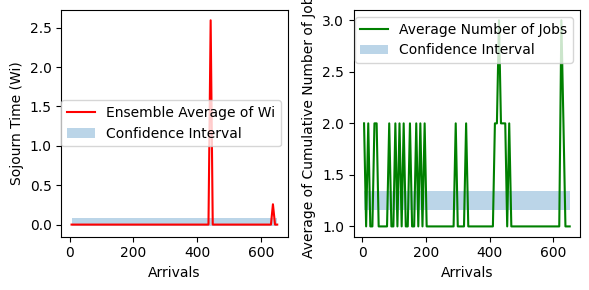

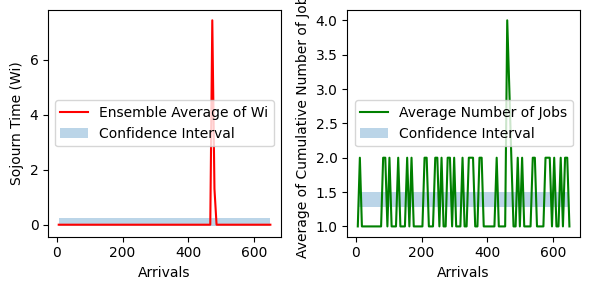

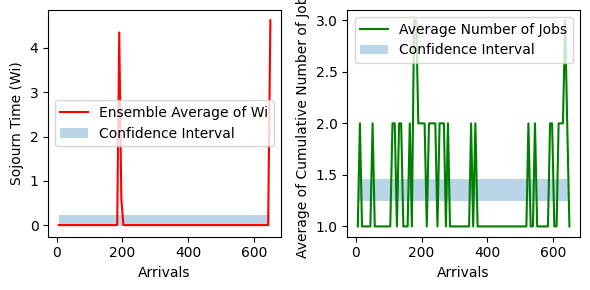

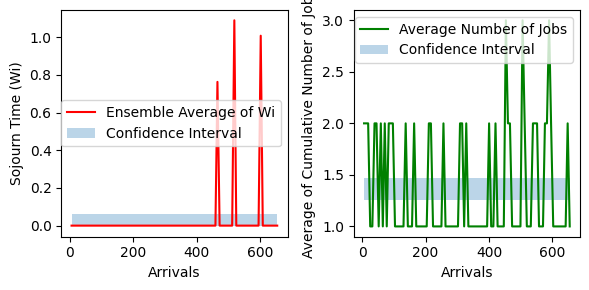

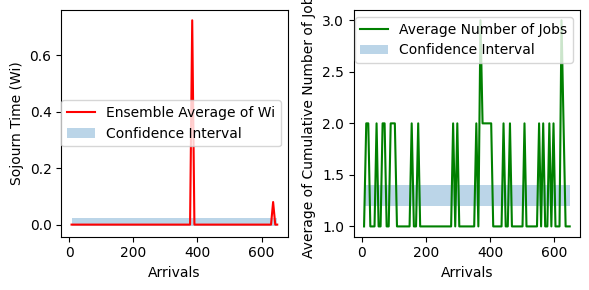

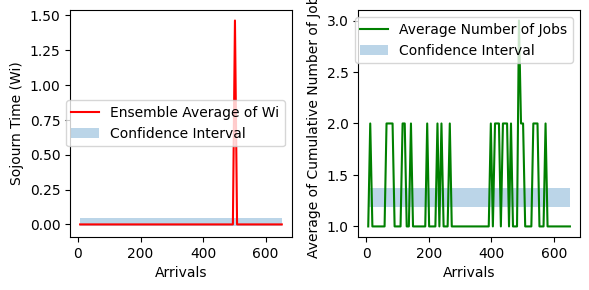

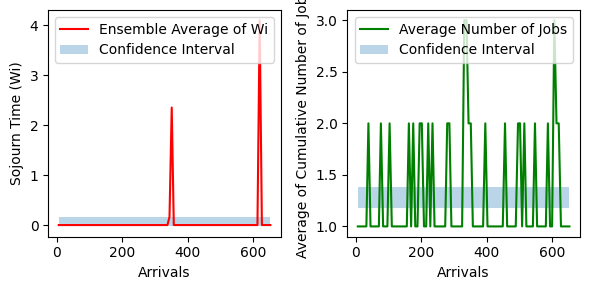

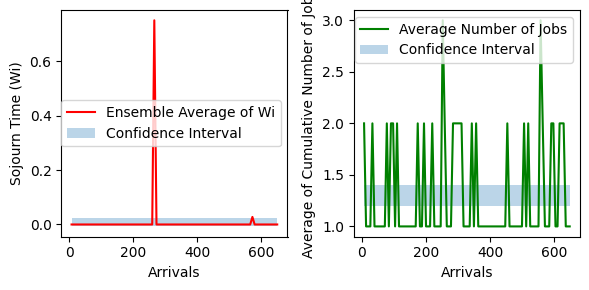

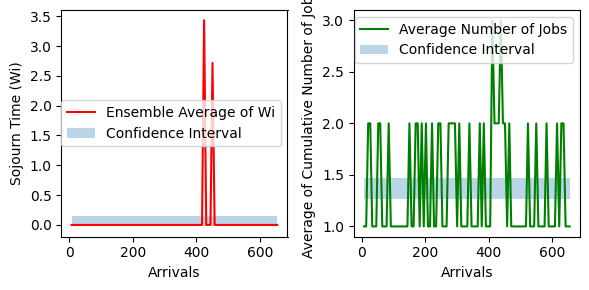

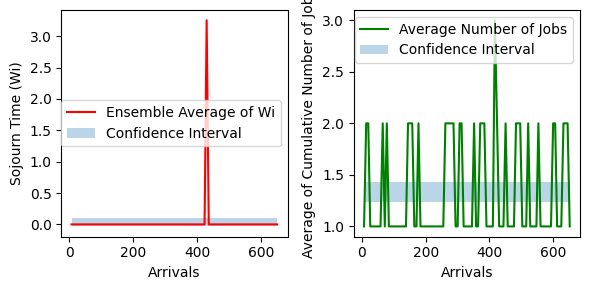

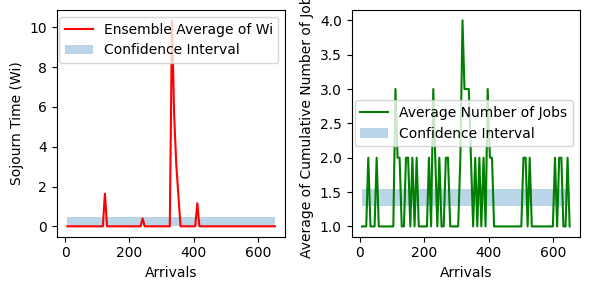

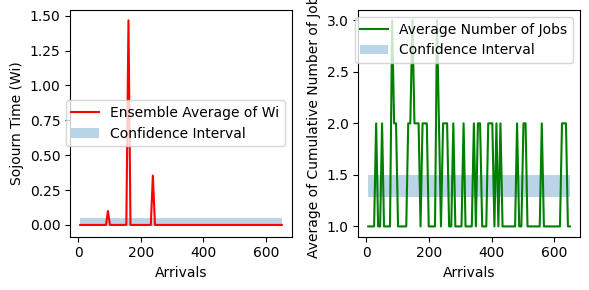

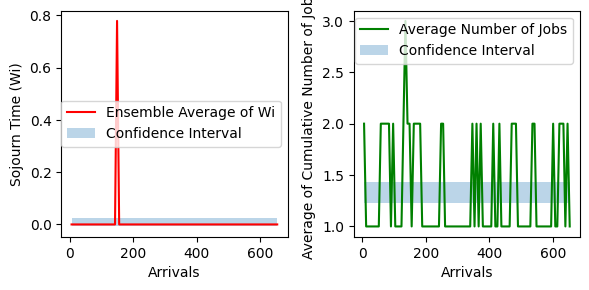

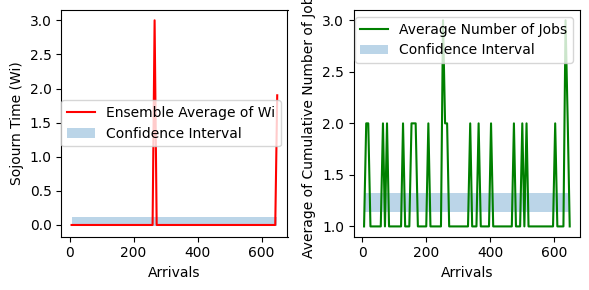

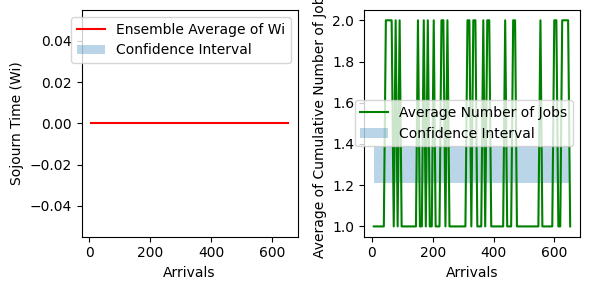

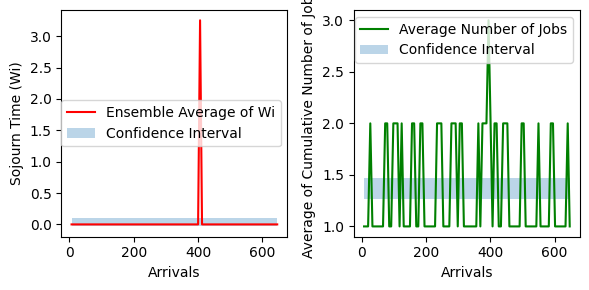

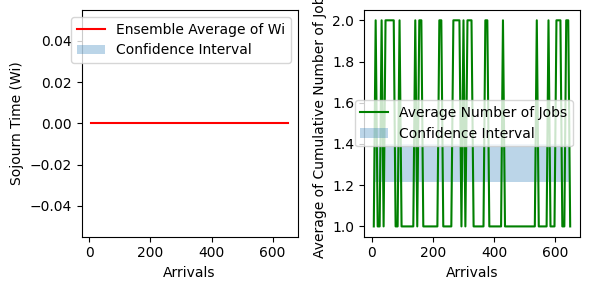

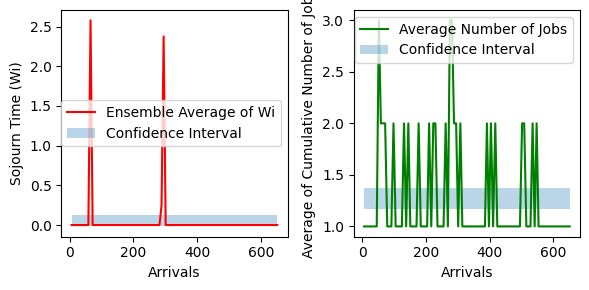

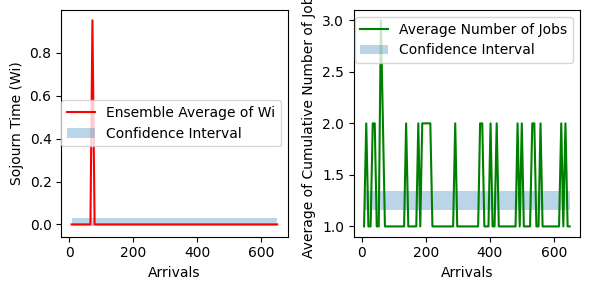

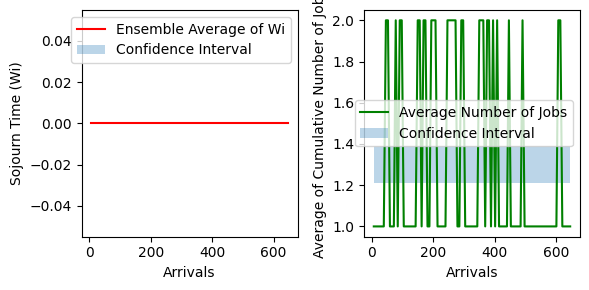

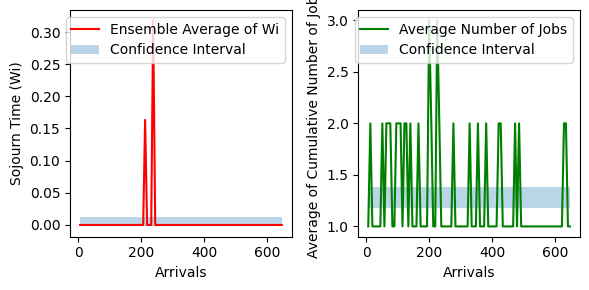

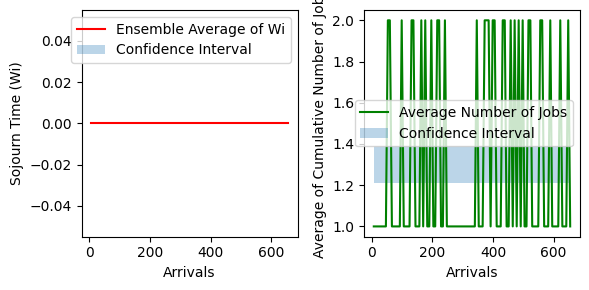

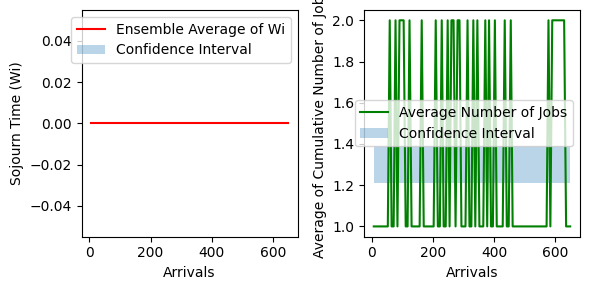

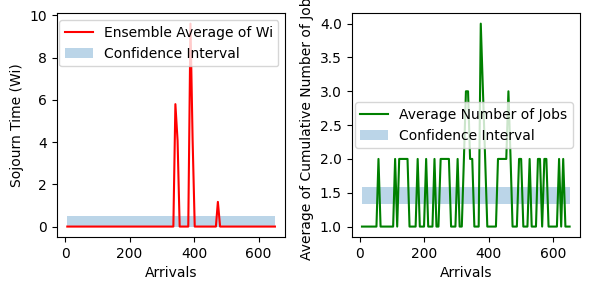

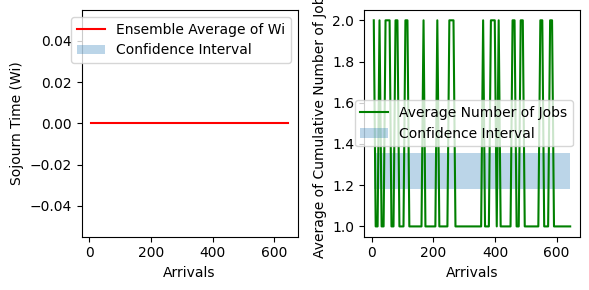

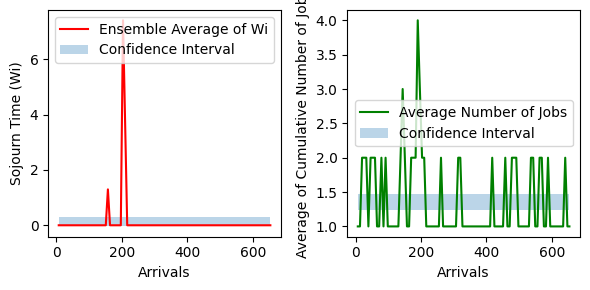

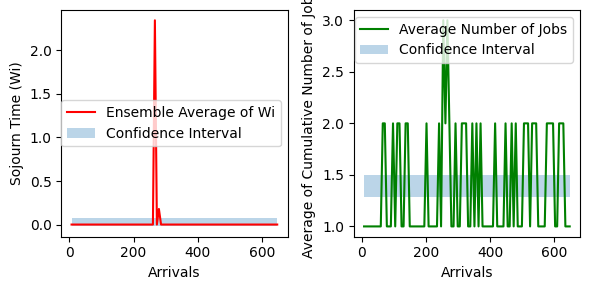

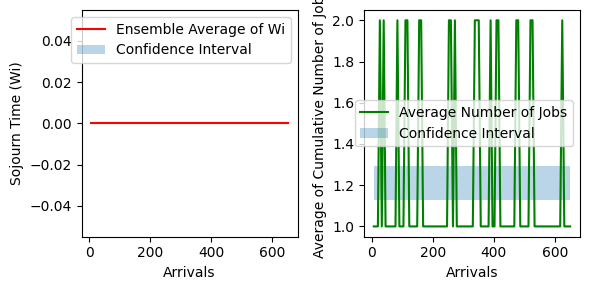

Warmup period for p = 0.7 and 30 replications: [48, 67, 72, 99, 78, 58, 76, 94, 57, 40, 64, 65, 50, 24, 22, 40, 1, 62, 1, 9, 10, 1, 36, 1, 1, 59, 1, 30, 40, 1]


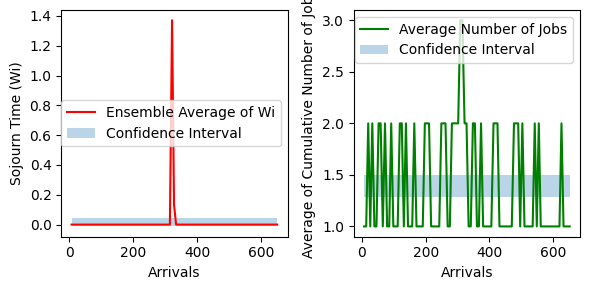

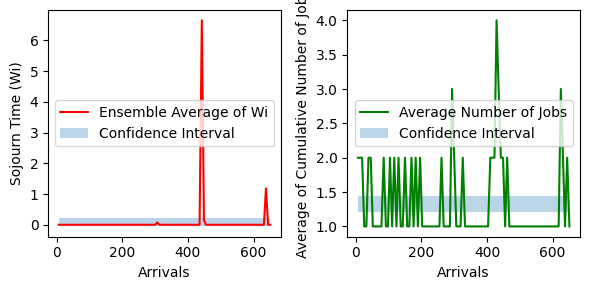

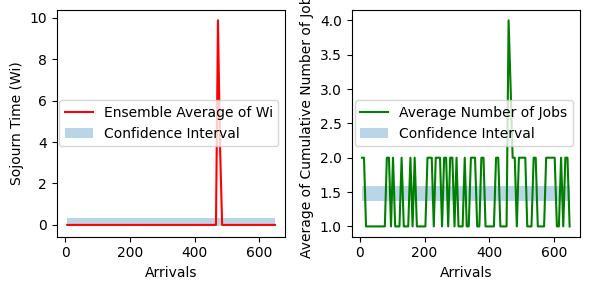

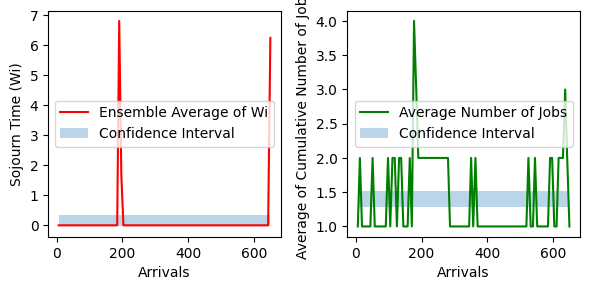

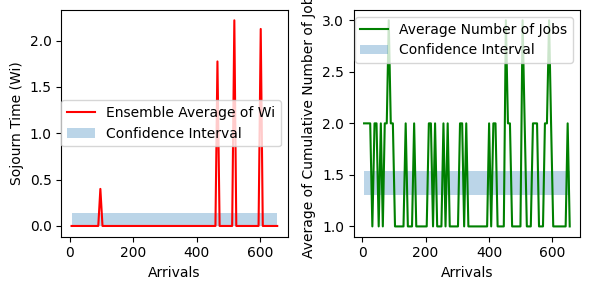

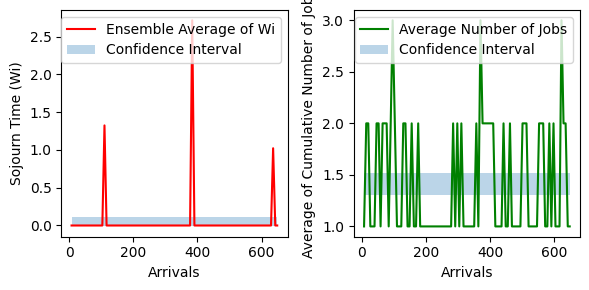

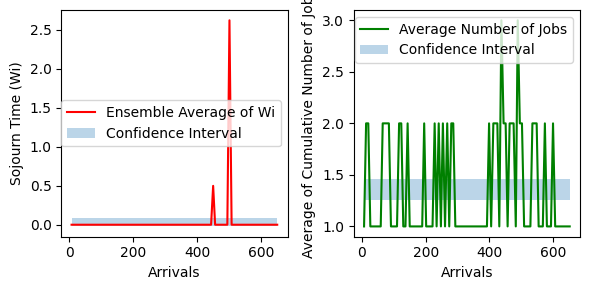

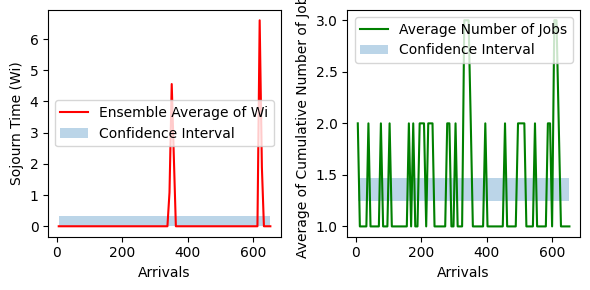

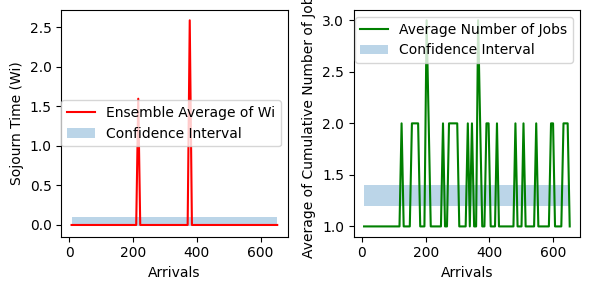

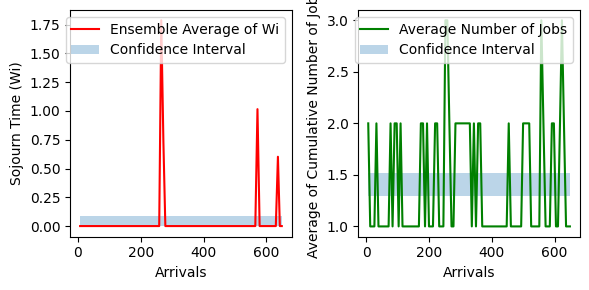

Warmup period for p = 0.8 and 10 replications: [48, 67, 72, 28, 78, 58, 76, 94, 57, 40]


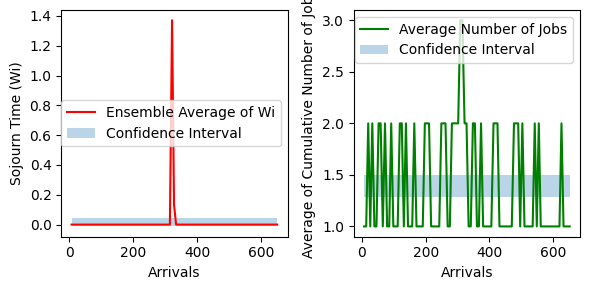

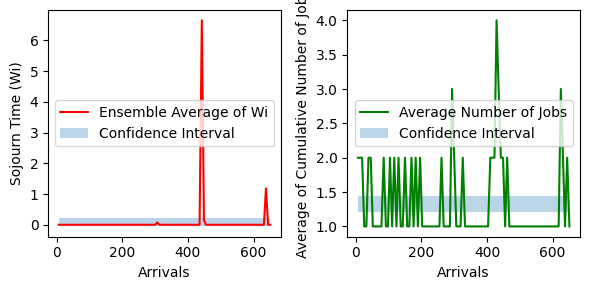

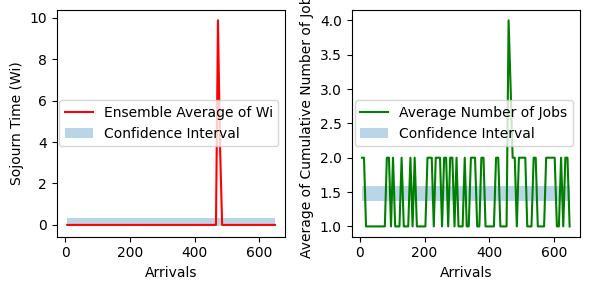

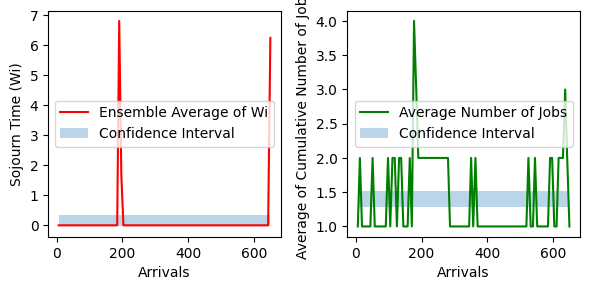

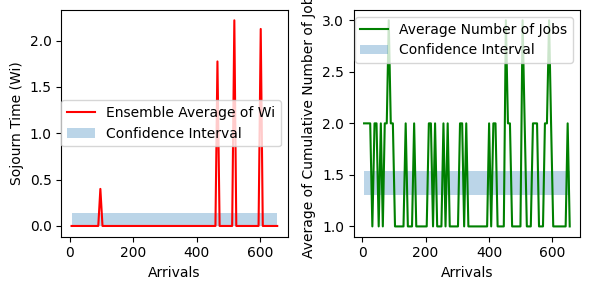

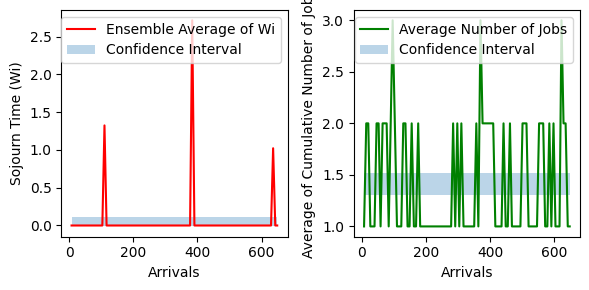

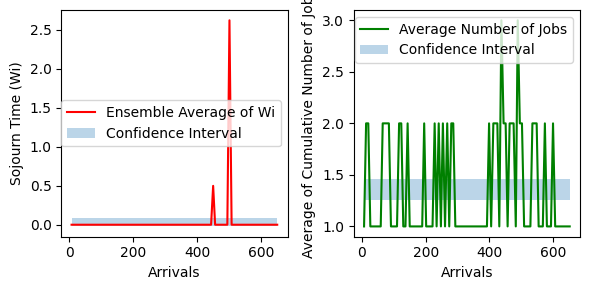

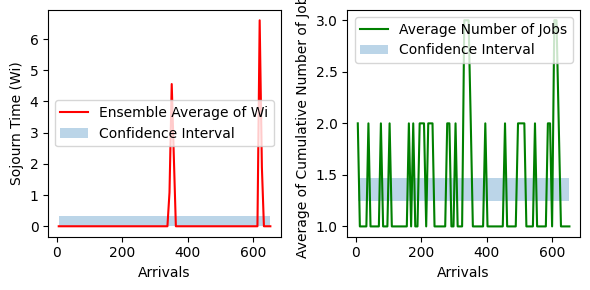

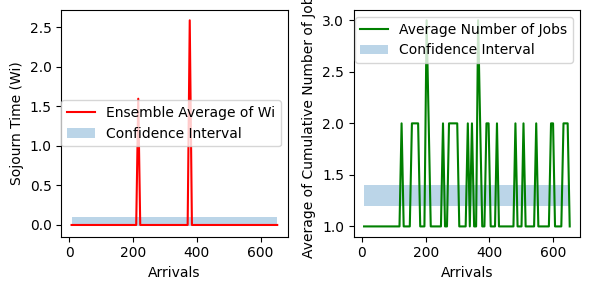

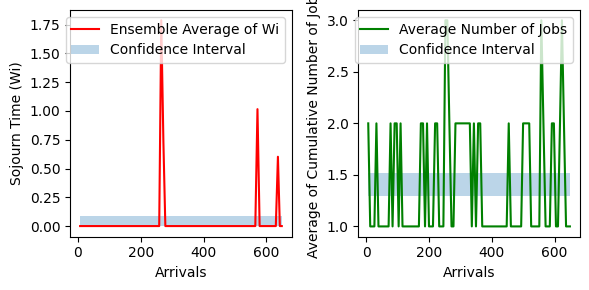

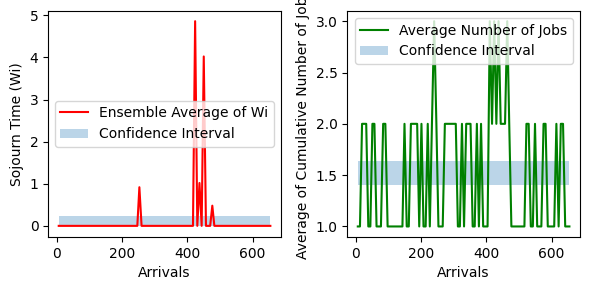

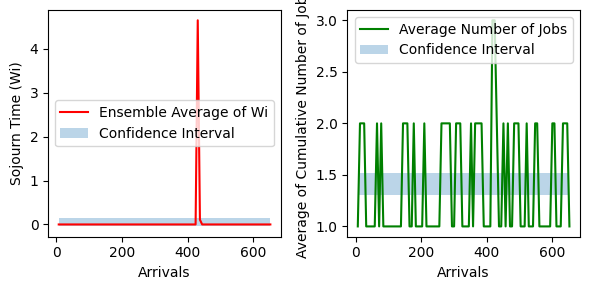

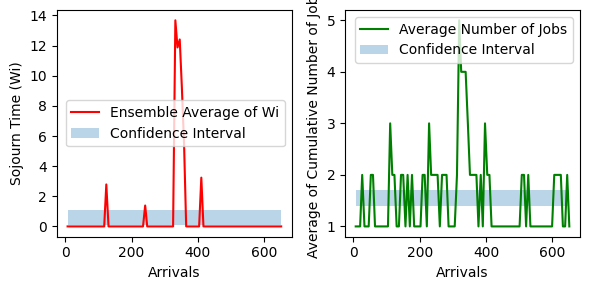

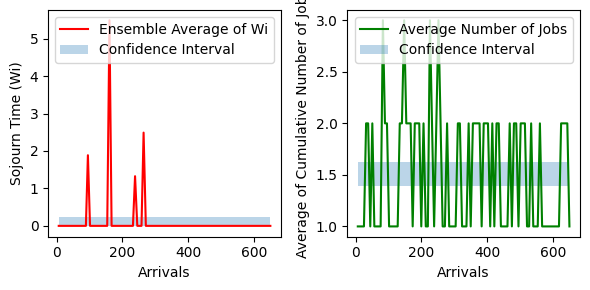

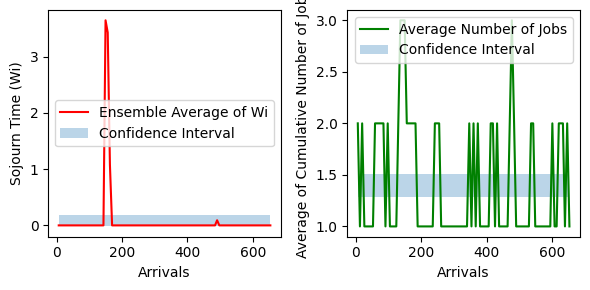

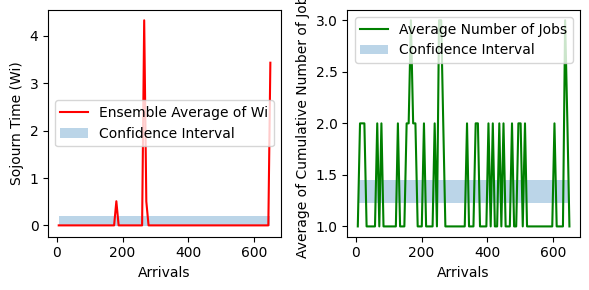

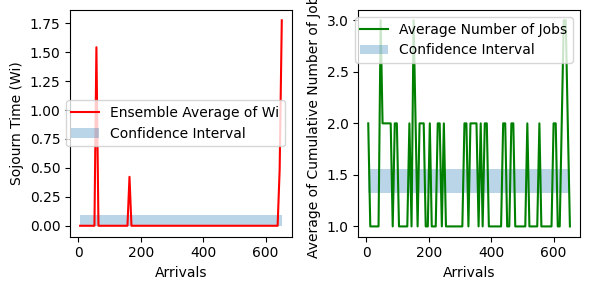

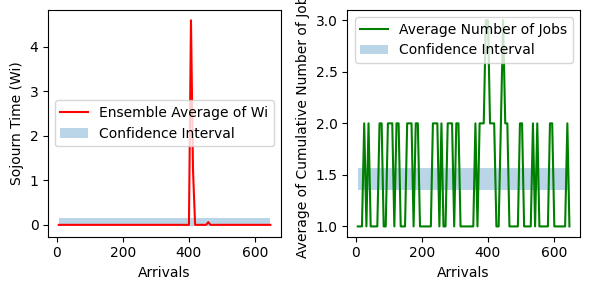

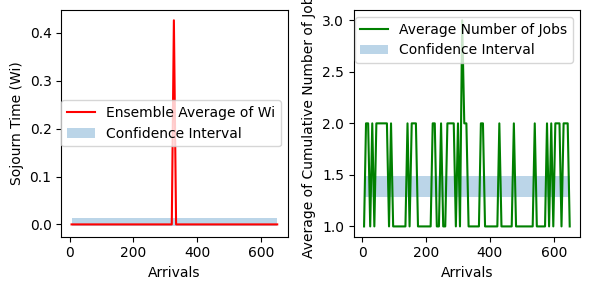

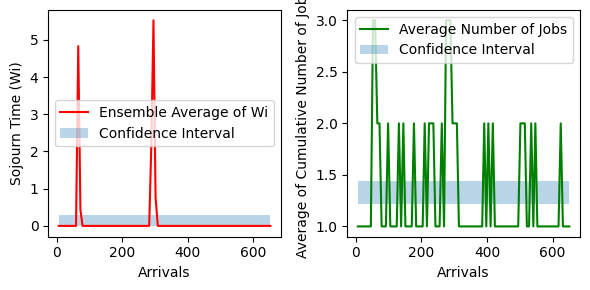

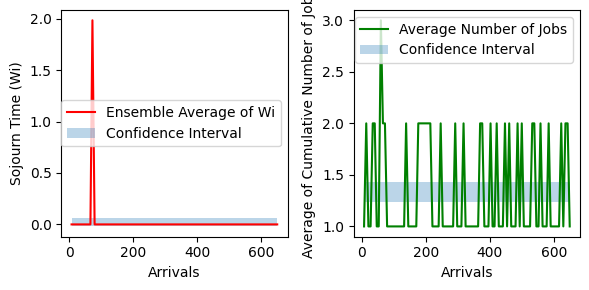

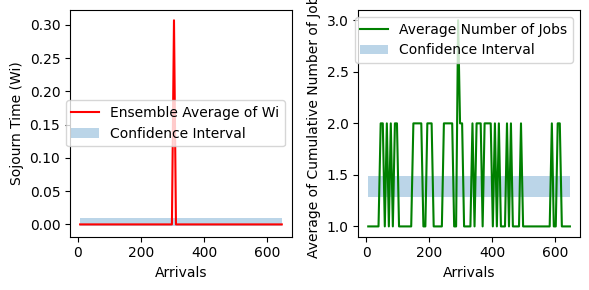

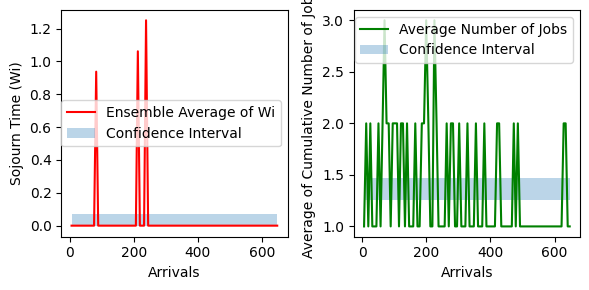

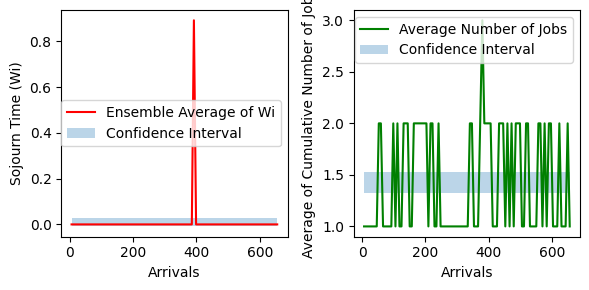

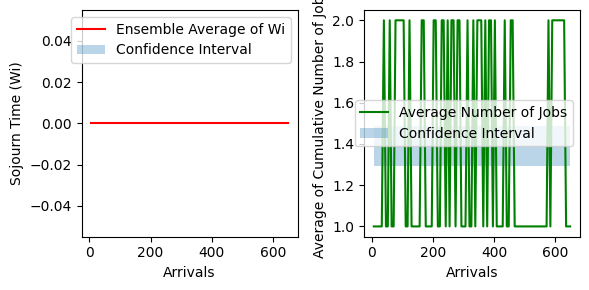

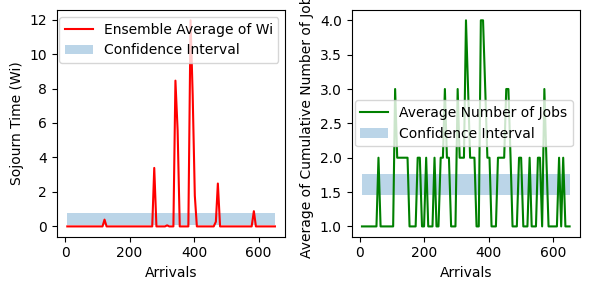

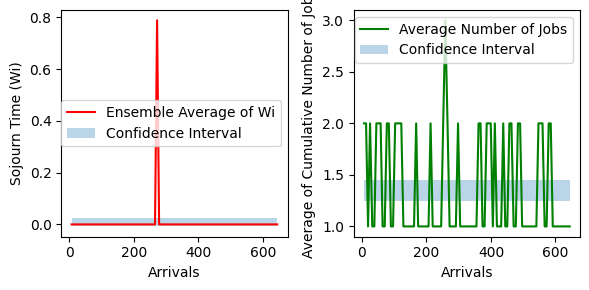

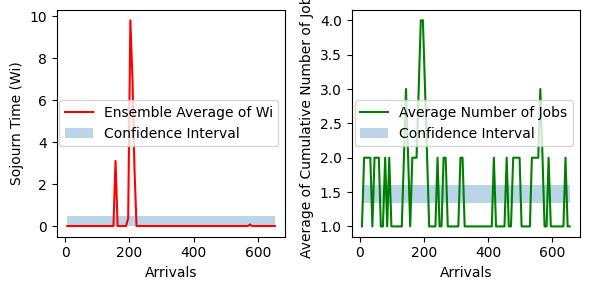

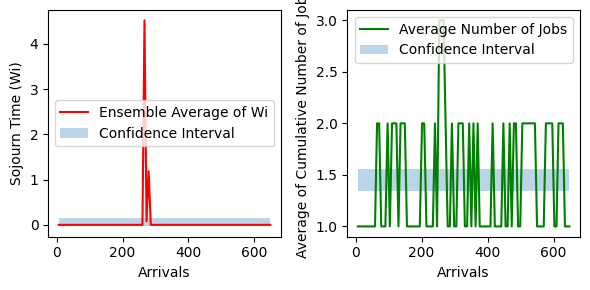

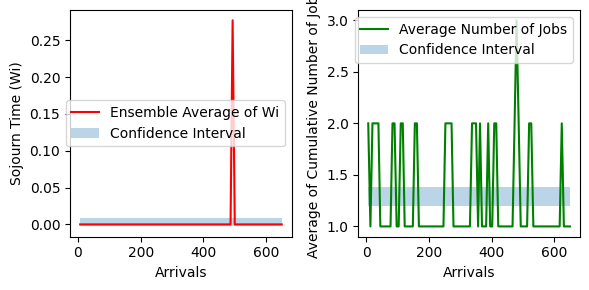

Warmup period for p = 0.8 and 30 replications: [48, 67, 72, 28, 78, 58, 76, 94, 57, 40, 64, 65, 50, 24, 22, 40, 8, 62, 49, 9, 10, 46, 36, 59, 1, 59, 41, 30, 40, 75]


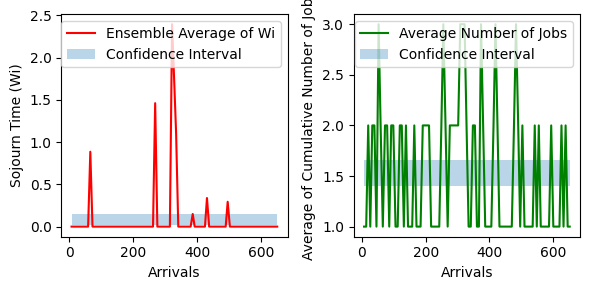

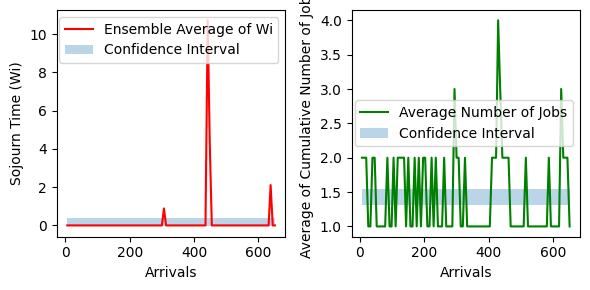

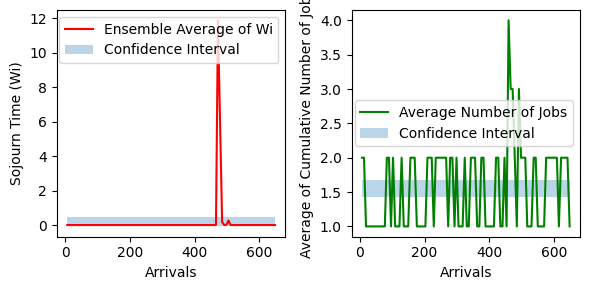

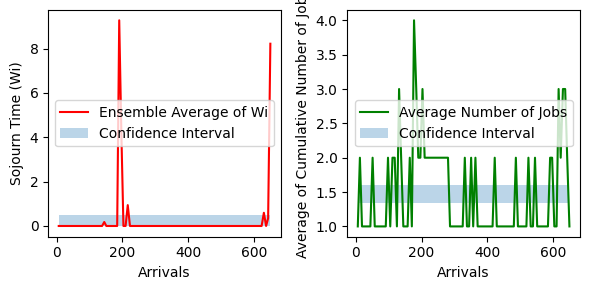

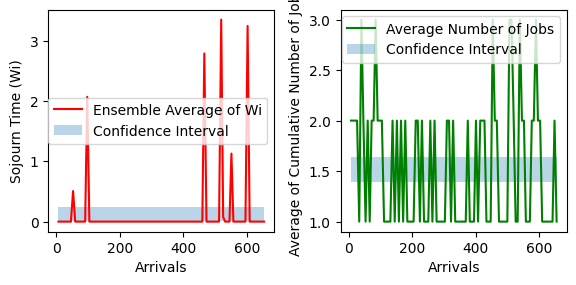

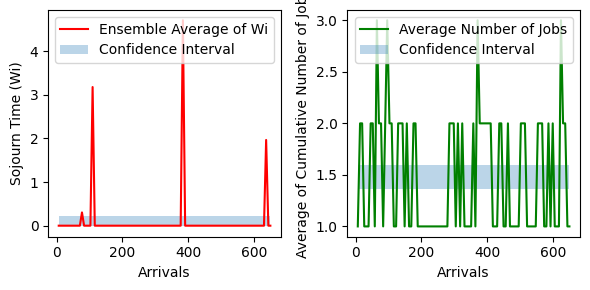

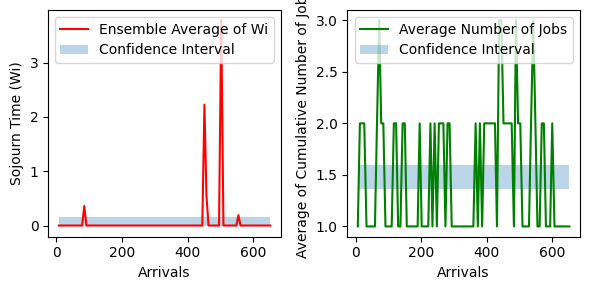

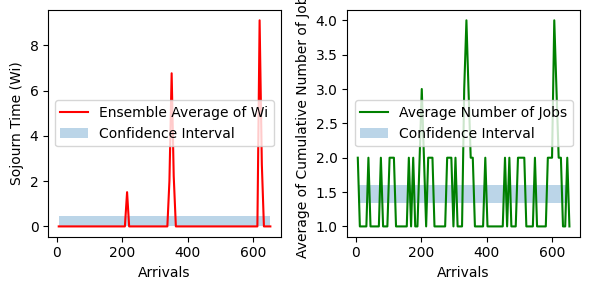

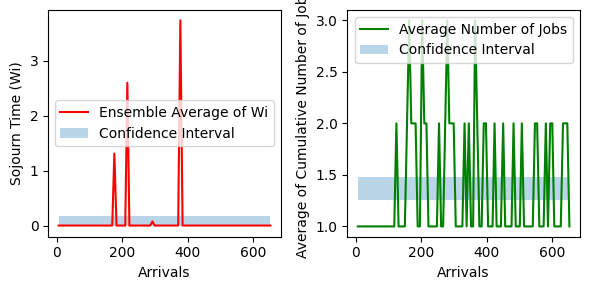

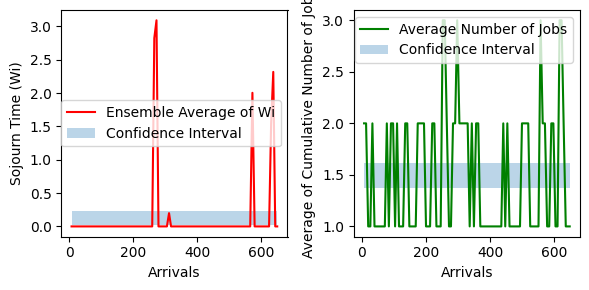

Warmup period for p = 0.9 and 10 replications: [48, 67, 72, 28, 78, 58, 76, 94, 57, 42]


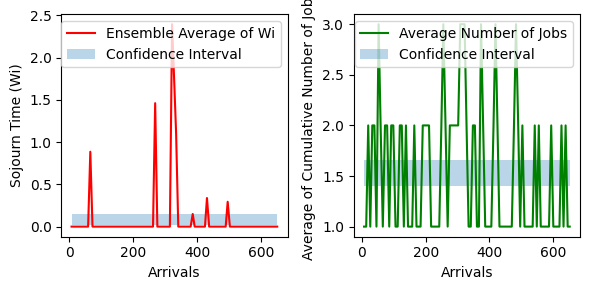

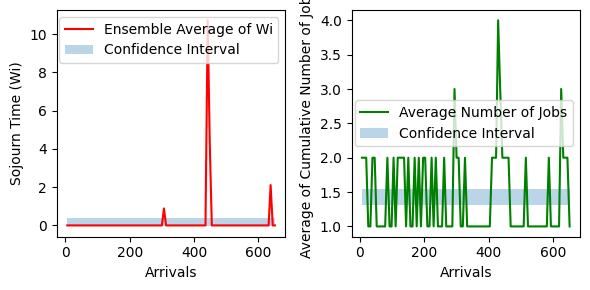

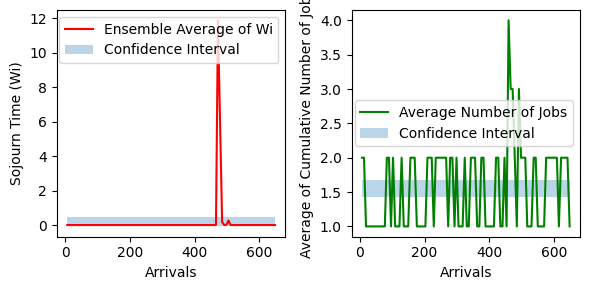

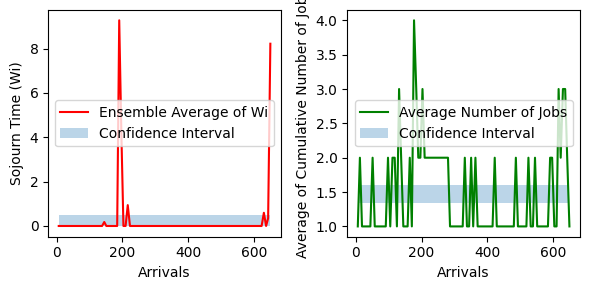

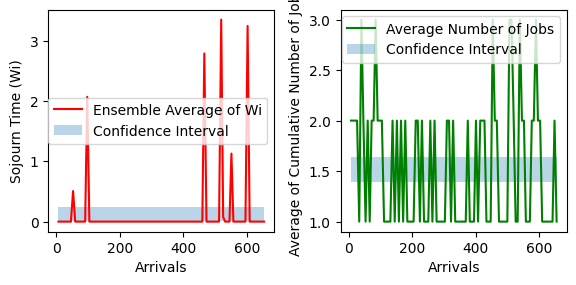

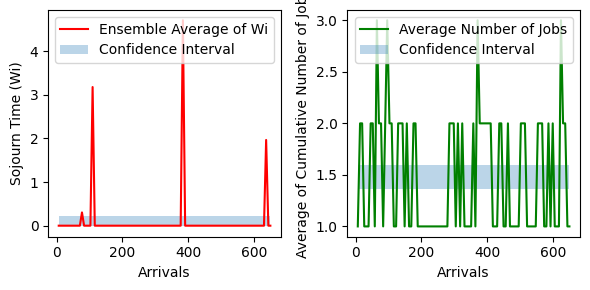

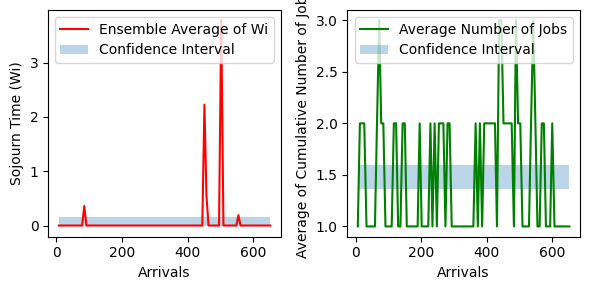

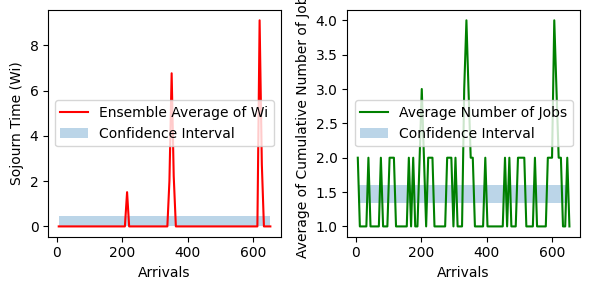

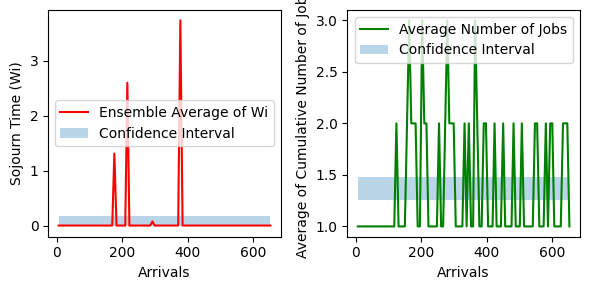

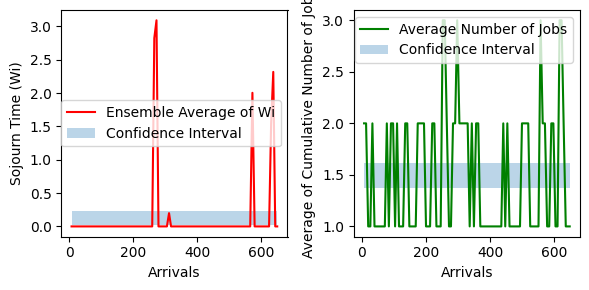

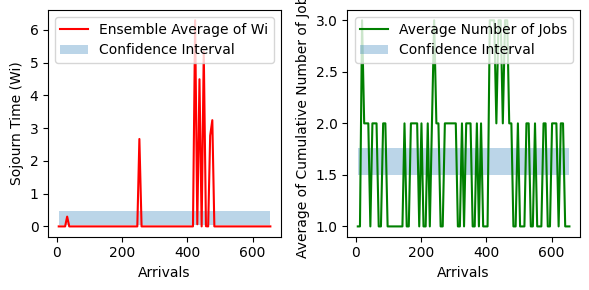

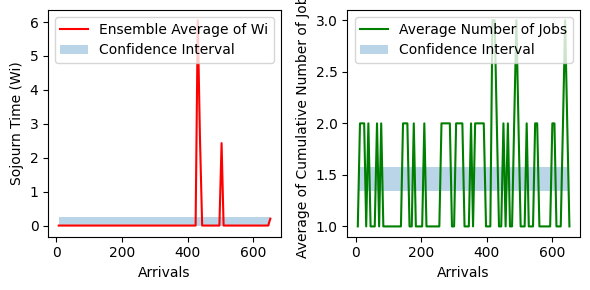

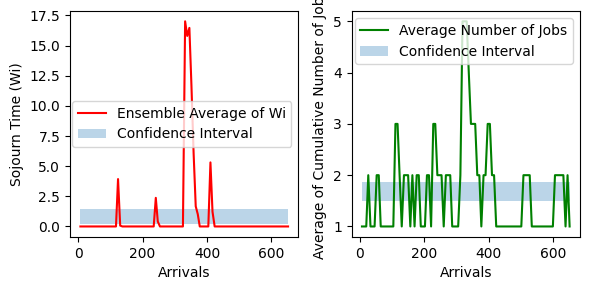

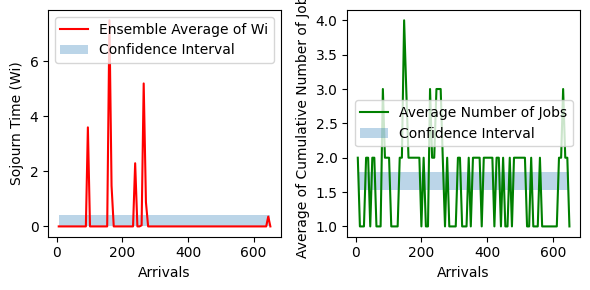

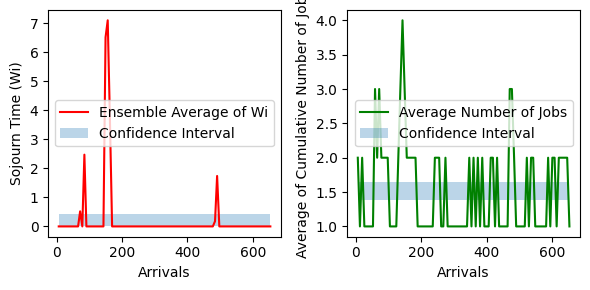

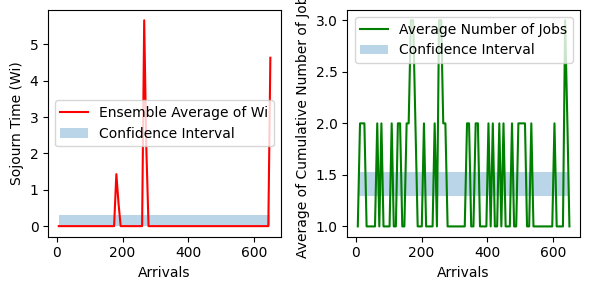

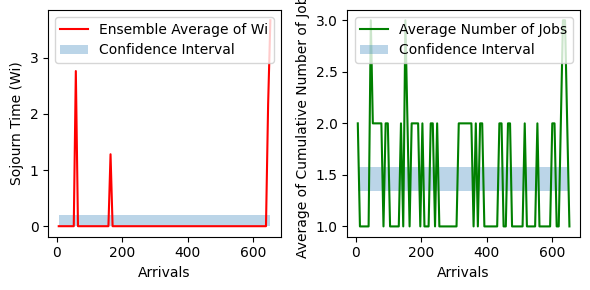

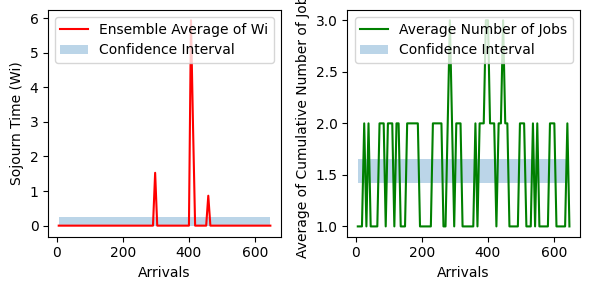

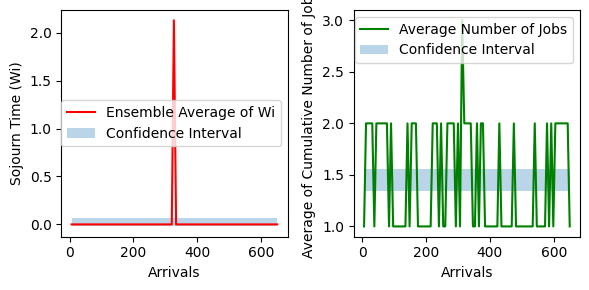

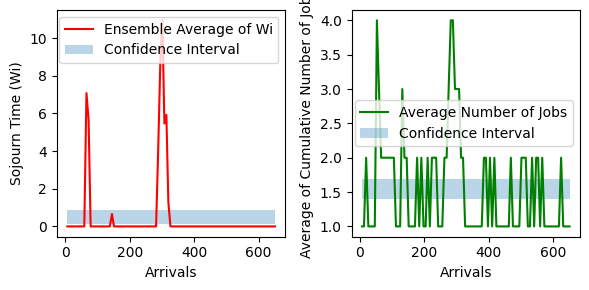

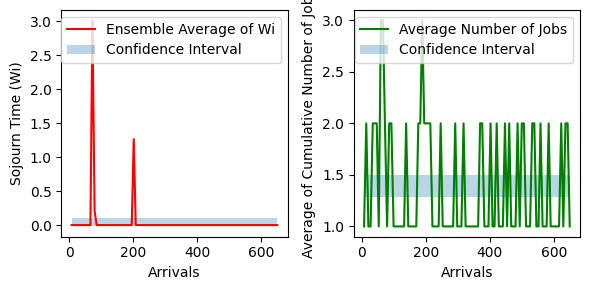

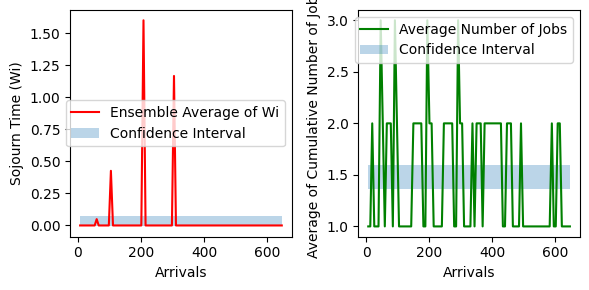

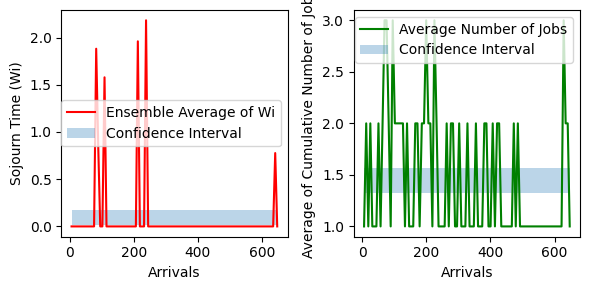

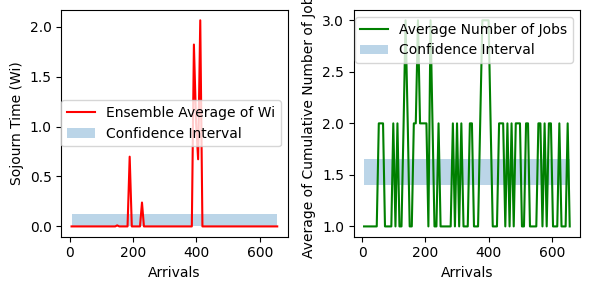

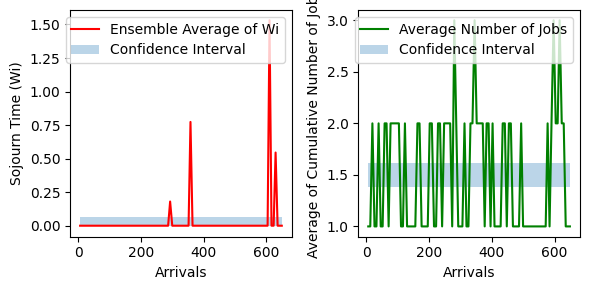

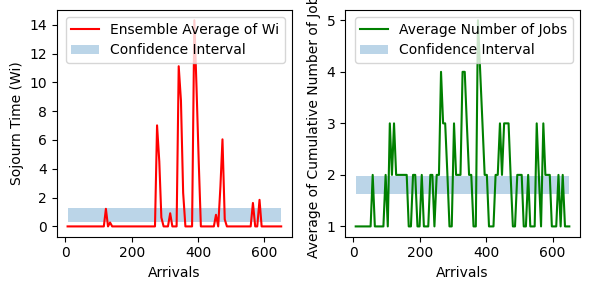

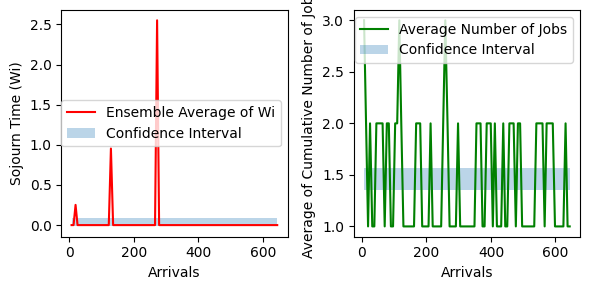

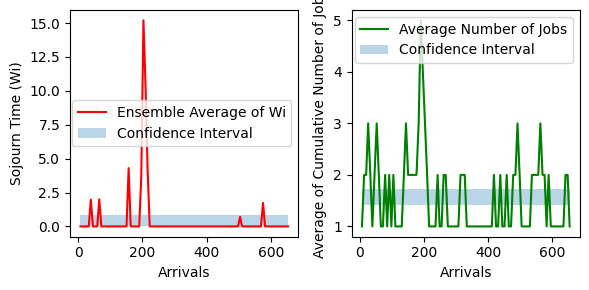

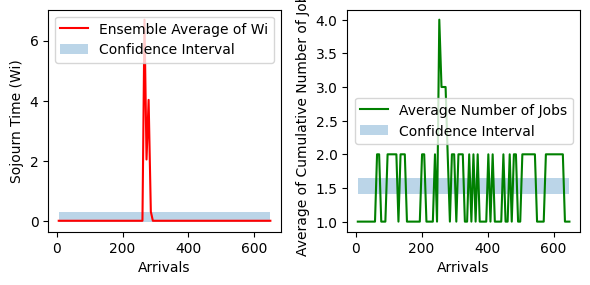

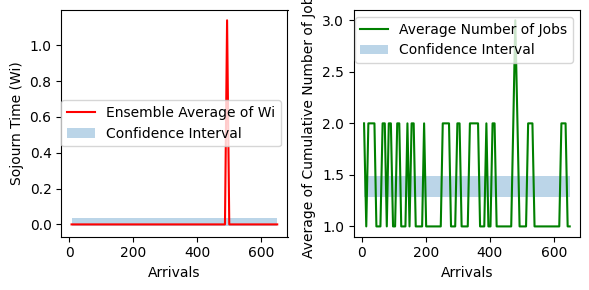

Warmup period for p = 0.9 and 30 replications: [48, 67, 72, 28, 78, 58, 76, 94, 57, 42, 64, 65, 50, 24, 22, 40, 8, 62, 49, 9, 10, 31, 36, 63, 93, 59, 41, 30, 40, 75]


In [27]:
for util in p:
    Ls = util * c  # average number of busy servers =>  ρ = Ls / c = λ / cµ -> Lecture 4 page 26 ρ = 0.6
    SERVICE_RATE = ARRIVAL_RATE / Ls   #  µ =  λ / Ls
    for runs in [10,30]:
        warmup_period = []
        for r in range(runs):
            RANDOM_SEED = r * 100
            random.seed(RANDOM_SEED)
            arrivals = []
            sojourn_times = []
            cum_num_jobs = []
            env = simpy.Environment()
            server = simpy.Resource(env, capacity=c)
            env.process(job_generator(env, server))
            env.run(until=10000)  # Run simulation for a fixed time

            # Calculate the ensemble averages
            ensemble_wi = np.mean(sojourn_times, axis=0)
            avg_num_jobs = np.mean(cum_num_jobs, axis=0)
            
            """
            # by using normal distribution
            conf_int_wi = st.norm.interval(0.95, loc=ensemble_wi, scale=st.sem(sojourn_times))
            conf_int_avg_num_jobs = st.norm.interval(0.95, loc=avg_num_jobs, scale=st.sem(cum_num_jobs))
            """
            # Calculate confidence intervalsfor ensemble average of wi and average number of jobs with 95% level of significance
            # by using the t-distribution
            conf_int_wi = st.t.interval(0.95, len(sojourn_times) - 1, loc=ensemble_wi, scale=st.sem(sojourn_times)) 
            #scale = np.std(sojourn_times, axis=0) / np.sqrt(len(sojourn_times)))
            conf_int_avg_num_jobs = st.t.interval(0.95, len(cum_num_jobs) - 1, loc=avg_num_jobs, scale=st.sem(cum_num_jobs))
            #scale = np.std(cum_num_jobs, axis=0) / np.sqrt(len(cum_num_jobs)))

            # Plot the convergence graphs
            plot_convergence_graphs(arrivals, sojourn_times, cum_num_jobs, ensemble_wi, avg_num_jobs, conf_int_wi, conf_int_avg_num_jobs)

            # Determine the warmup period length when the values converge
            warmup_len = np.argmax(np.abs(np.diff(sojourn_times))) + 1  # Index where the difference is maximum
            warmup_period.append(warmup_len)

        print(f"Warmup period for p = {util} and {runs} replications: {warmup_period}")
        
        # solve how to create only two plot for 10 and 30 replications. Now it creates 2 plots for each run!!!